# Notebook to demonstrate SumMe labeling issues
Here we showcase to what extent to which the SumMe labels artifically lowers the F1 score results 

In [10]:
import h5py
import numpy as np
from Utils import knapSack
from ortools.algorithms.python import knapsack_solver
import seaborn as sns

In [4]:
solver = knapsack_solver.KnapsackSolver(
        knapsack_solver.SolverType.KNAPSACK_DYNAMIC_PROGRAMMING_SOLVER,
        "KnapsackExample",
    )

data = h5py.File('Data/original/googlenet_summe.h5')

In [5]:
def create_shot_bound_dict(change_points,user_summaries):
    shot_bound_dict = {}
    j = 0
    for user_summary in user_summaries:
        values = [ ] #Percentage of 1s
        weights = [] # Number of frames
        shot_bound_dict[j] = {}
        for i, change_point in enumerate(change_points):
            values.append(int(np.count_nonzero(user_summary[change_point[0]:change_point[1]])*100/len(user_summary[change_point[0]:change_point[1]])))
            weights.append(len(user_summary[change_point[0]:change_point[1]]))
        shot_bound_dict[j]['values'] = values
        shot_bound_dict[j]['weights'] = weights
        j+=1
    return shot_bound_dict

def knapsack_weight_creation(shot_bound_dict,capacities):
    all_packed_weights = []
    all_packed_items = []
    all_percentages = []
    for k in range(len(shot_bound_dict)) :   
        solver.init(shot_bound_dict[k]['values'], [shot_bound_dict[k]['weights']], capacities)
        computed_value = solver.solve()
        packed_items = []
        packed_weights = []
        total_weight = 0
        percentage_frames = []
        print("Total value =", computed_value)
        for i in range(len(shot_bound_dict[k]['values'])):
            if solver.best_solution_contains(i):
                packed_items.append(i)
                packed_weights.append(shot_bound_dict[k]['weights'][i])
                total_weight += shot_bound_dict[k]['weights'][i]
                percentage_frames.append(shot_bound_dict[k]['values'][i])
        all_packed_items.append(packed_items)
        all_packed_weights.append(packed_weights)
        all_percentages.append(percentage_frames)
    return all_packed_weights,all_packed_items,all_percentages


def whole_pred(change_points,n_frames,packed_items):
    expected_prediction = np.zeros(n_frames)
    for selected_shot in packed_items:
        expected_prediction[change_points[selected_shot][0]:change_points[selected_shot][1]]  = 1 
    return expected_prediction



def f1(predicted_summary,user_summary):
    max_len = max(predicted_summary.shape[0],user_summary.shape[0])
    S = np.zeros(max_len, dtype=int)
    G = np.zeros(max_len, dtype=int)
    S[:len(predicted_summary)] = predicted_summary

    G[:max_len] = user_summary
    overlapped = S & G

        # Compute precision, recall, f-score
    precision = sum(overlapped)/sum(S)
    recall = sum(overlapped)/sum(G)
    print(2 * precision * recall * 100 / (precision + recall))
    return 2 * precision * recall * 100 / (precision + recall)

In [6]:
results_dict = {} 
for video_key in list(data.keys()):
    results_dict[video_key] = {} 
    video_data = data[video_key]
    change_points = video_data['change_points']
    user_summaries = video_data['user_summary']
    n_frames = int(video_data['n_frames'][...])
    capacities = [int(video_data['n_frames'][...]*0.15)]
    shot_bound_dict = create_shot_bound_dict(change_points,user_summaries)
    all_packed_weights,all_packed_items,all_percentages = knapsack_weight_creation(shot_bound_dict,capacities)
    total_mean = []
    for percentages in all_percentages:
        total_mean.append(np.mean(percentages))
    results_dict[video_key]['Average reduction'] = np.mean(total_mean)
    average_user_f1_score  = []
    overall_F1_score = []
    for packed_items,user_summary in zip(all_packed_items,user_summaries):
        full_prediction = whole_pred(change_points,n_frames,packed_items)
        f1_score = f1(full_prediction,user_summary)
        average_user_f1_score.append(f1_score)
    results_dict[video_key]['Reduced F1 Score']  = np.mean(average_user_f1_score)
    
    overall_F1_score.append(average_user_f1_score)
print(np.mean(overall_F1_score))

Total value = 750
Total value = 597
Total value = 721
Total value = 640
Total value = 398
Total value = 249
Total value = 733
Total value = 503
Total value = 786
Total value = 499
Total value = 580
Total value = 387
Total value = 659
Total value = 531
Total value = 649
69.8170731707317
82.75328692962104
67.02290076335876
61.561561561561554
79.86406117247238
49.41176470588234
80.76335877862596
66.23058053965659
90.3585657370518
46.00448095593727
65.1685393258427
60.856031128404666
78.51500789889415
60.65830721003136
85.91065292096219
Total value = 876
Total value = 752
Total value = 593
Total value = 580
Total value = 780
Total value = 539
Total value = 716
Total value = 720
Total value = 981
Total value = 900
Total value = 973
Total value = 945
Total value = 758
Total value = 661
Total value = 919
77.00276243093923
77.92392463562034
61.38613861386138
78.10650887573964
88.36191171105435
64.01544401544402
65.36449250087199
59.58494548012662
80.38875390489413
93.74140302613479
82.12194281

C:\Users\P70088666\AppData\Local\Temp\ipykernel_18744\2015276901.py:60: RuntimeWarning: invalid value encountered in scalar divide
  print(2 * precision * recall * 100 / (precision + recall))
C:\Users\P70088666\AppData\Local\Temp\ipykernel_18744\2015276901.py:61: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * precision * recall * 100 / (precision + recall)


53.921568627450974
74.15730337078652
42.76048714479026
43.82022471910112
68.30985915492957
73.99527186761229
34.46658851113716
60.148514851485146
Total value = 384
Total value = 714
Total value = 508
Total value = 240
Total value = 363
Total value = 431
Total value = 568
Total value = 554
Total value = 560
Total value = 394
Total value = 415
Total value = 183
Total value = 356
Total value = 539
Total value = 341
65.65603763721903
80.30803080308031
77.29357798165138
57.937310414560166
71.87985499741066
56.76605504587157
74.98736735725113
77.32647814910027
62.16768916155419
55.04682622268469
57.81420765027322
51.47392290249433
49.798792756539235
74.67467467467468
51.95402298850575
Total value = 204
Total value = 161
Total value = 111
Total value = 133
Total value = 149
Total value = 153
Total value = 210
Total value = 138
Total value = 194
Total value = 127
Total value = 116
Total value = 94
Total value = 238
Total value = 140
Total value = 85
Total value = 196
Total value = 137
67.28624

In [8]:
print(f'Mean F1 score reduction over the whole dataset: {np.mean(overall_F1_score)}')
print(f'F1 score reduction standard deviation over the whole dataset: {np.var(overall_F1_score)**(1/2)}')

Mean F1 score reduction over the whole dataset: 66.97610633964824
F1 score reduction variance over the whole dataset: 10.292736609277489


In [ ]:
shot_indices = data

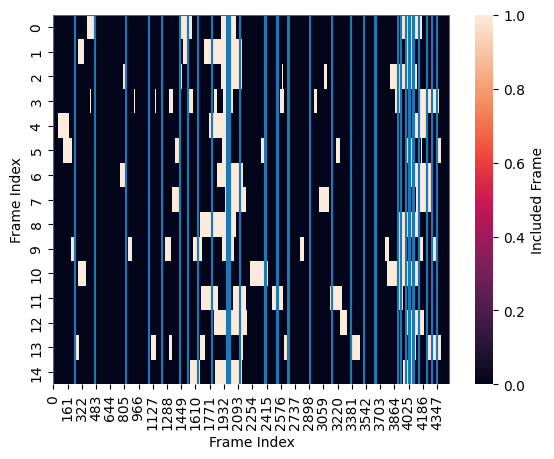

: 

In [12]:
ax = sns.heatmap(data['video_1']["user_summary"][...],cbar_kws={'label': 'Included Frame'})
ax.set(xlabel="Frame Index", ylabel="Frame Index")
ax.hlines(data['video_1']["change_points"][...].flatten(), *ax.get_xlim())
ax.vlines(data['video_1']["change_points"][...].flatten(), *ax.get_ylim())